This dataset gives a number of variables along with a target condition of having or not having heart disease. It contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database is the only one that has been used by ML researchers to this date. The "goal" field refers to the presence of heart disease in the patient.

### Imports

In [1]:
# import numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# import sklearn for dealing with categorical features
from sklearn.preprocessing import LabelEncoder

# split the data set for training, validation set, and use cross validation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold


# model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

# scale the data
from sklearn.preprocessing import MinMaxScaler

# File system management
import os

# no warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib ans seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()


# classification algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# feature selection algorithms
from sklearn.feature_selection import f_classif,chi2, mutual_info_classif, SelectKBest

### Lets read the data

In [2]:
df = pd.read_csv('heart.csv')
print(f'Data shape {df.shape}')
df.head(5)

Data shape (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### Exploratory Data Analysis

#### Target

In [3]:
df['target'].value_counts()

1    165
0    138
Name: target, dtype: int64

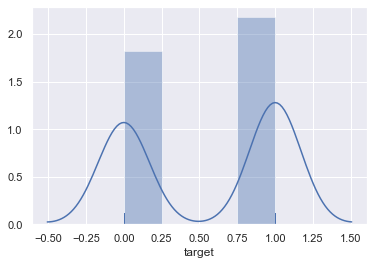

In [4]:
sns.distplot(df['target'],rug=True)
plt.show()

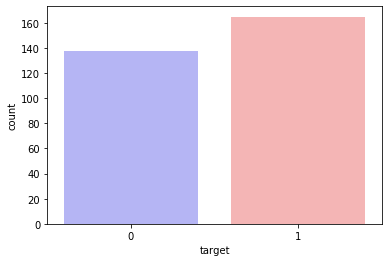

In [5]:
sns.countplot(x='target', data=df, palette="bwr")
plt.show()

We can see the the distribution of the targets is balanced! 

#### Age

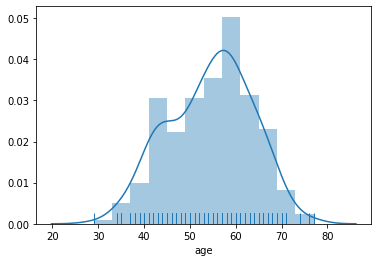

In [6]:
sns.distplot(df['age'], rug=True)
plt.show()

#### Sex

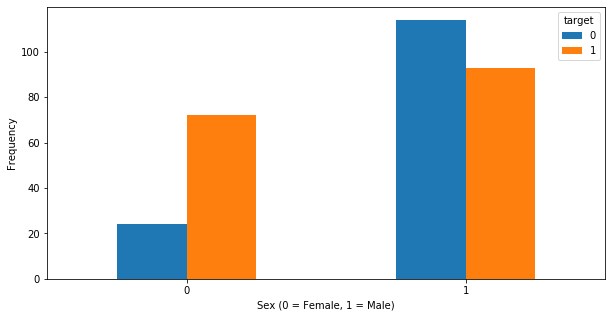

In [7]:
pd.crosstab(df.sex, df.target).plot(kind='bar', figsize=(10,5))
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

### Missing Values

In [4]:
def missing_values_table(df):
    
    miss_values = df.isna().sum()
    
    miss_values_percent = 100 * df.isna().sum() / len(df)
    
    miss_values_table = pd.concat([miss_values, miss_values_percent], axis=1)
    
    miss_values_table = miss_values_table.rename(columns = {0 : 'Missing values', 1 : '% of total values'})
    
    miss_values_table = miss_values_table[miss_values_table.iloc[:,1] != 0].sort_values('% of total values', ascending=False).round(1)
    
    print('The data have ' + str(df.shape[1]) + ' features.\n'
          'There are ' + str(miss_values_table.shape[0]) + ' features with missing values')
    
    return miss_values_table

In [5]:
missing_values_table(df)

The data have 14 features.
There are 0 features with missing values


,Missing values,% of total values


### Column Types

In [6]:
df.dtypes.value_counts()

int64      13
float64     1
dtype: int64

In [7]:
df.select_dtypes('float64').apply(pd.Series.nunique, axis = 0)

oldpeak    40
dtype: int64

In [8]:
df.select_dtypes('int64').apply(pd.Series.nunique, axis = 0)

age          41
sex           2
cp            4
trestbps     49
chol        152
fbs           2
restecg       3
thalach      91
exang         2
slope         3
ca            5
thal          4
target        2
dtype: int64

### One-Hot encoding

Our categorical features are already with label encoding. Due to small features space and small labels we will use one 
hot encoding for more information about our features.

In [9]:
cat_features = []
def extract_cat_features(df):
    for i in df.columns:
        if len(df[i].unique()) > 2 and len(df[i].unique()) < 10:
            cat_features.append(i)
        else:
            continue
extract_cat_features(df)

In [10]:
df = pd.get_dummies(data=df, columns=cat_features, drop_first=True)
df.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,target,cp_1,...,restecg_2,slope_1,slope_2,ca_1,ca_2,ca_3,ca_4,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,1,0,...,0,0,0,0,0,0,0,1,0,0
1,37,1,130,250,0,187,0,3.5,1,0,...,0,0,0,0,0,0,0,0,1,0
2,41,0,130,204,0,172,0,1.4,1,1,...,0,0,1,0,0,0,0,0,1,0
3,56,1,120,236,0,178,0,0.8,1,1,...,0,0,1,0,0,0,0,0,1,0
4,57,0,120,354,0,163,1,0.6,1,0,...,0,0,1,0,0,0,0,0,1,0


In [12]:
col_at_end = ['target']
df = df[[c for c in df if c not in col_at_end] + [c for c in col_at_end if c in df]]

In [13]:
df.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,cp_1,cp_2,...,slope_1,slope_2,ca_1,ca_2,ca_3,ca_4,thal_1,thal_2,thal_3,target
0,63,1,145,233,1,150,0,2.3,0,0,...,0,0,0,0,0,0,1,0,0,1
1,37,1,130,250,0,187,0,3.5,0,1,...,0,0,0,0,0,0,0,1,0,1
2,41,0,130,204,0,172,0,1.4,1,0,...,0,1,0,0,0,0,0,1,0,1
3,56,1,120,236,0,178,0,0.8,1,0,...,0,1,0,0,0,0,0,1,0,1
4,57,0,120,354,0,163,1,0.6,0,0,...,0,1,0,0,0,0,0,1,0,1


### Scaling

In [14]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df.iloc[:,:-1].values)
df = pd.DataFrame(data=np.concatenate((df_scaled, df.iloc[:,-1].values.reshape((-1,1))), axis=1), columns=df.columns.to_list())

In [11]:
df.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,cp_1,cp_2,...,slope_1,slope_2,ca_1,ca_2,ca_3,ca_4,thal_1,thal_2,thal_3,target
0,0.708333,1.0,0.481132,0.244292,1.0,0.603053,0.0,0.370968,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.166667,1.0,0.339623,0.283105,0.0,0.885496,0.0,0.564516,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.250000,0.0,0.339623,0.178082,0.0,0.770992,0.0,0.225806,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.562500,1.0,0.245283,0.251142,0.0,0.816794,0.0,0.129032,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.583333,0.0,0.245283,0.520548,0.0,0.702290,1.0,0.096774,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


### Comparing splitting sizes various online solvers

training RF
training SVC
training Logist
training LDA


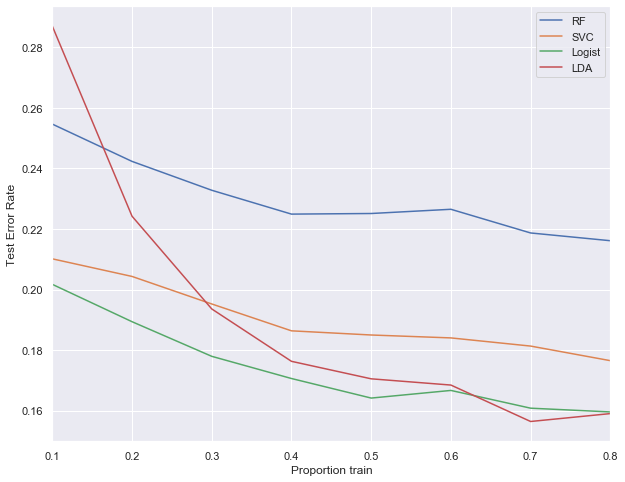

In [15]:
holdout = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
rounds = 60
plt.figure(figsize=(10,8))
classfiers = [('RF', RandomForestClassifier()),
              ('SVC', SVC(gamma='scale')),
              ('Logist', LogisticRegression(penalty='l2')),
              ('LDA', LinearDiscriminantAnalysis())]

xx = 1.0 - np.array(holdout)

for name, clf in classfiers:
    print('training %s' % name)
    rng = np.random.RandomState(0)
    yy = []
    for i in holdout:
        yy_ = []
        for r in range(rounds):
            X_train, X_test, y_train, y_test = \
                train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=i, stratify=df.iloc[:,-1], random_state=rng)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            yy_.append(1 - np.mean(y_pred == y_test))
        yy.append(np.mean(yy_))
    plt.plot(xx, yy, label=name)
plt.xlim([min(xx), max(xx)])
plt.legend(loc="upper right")
plt.xlabel("Proportion train")
plt.ylabel("Test Error Rate")
plt.style.use('seaborn-paper')
plt.grid(True)
plt.show()

### Feature Selection

In [18]:
X_, y_ = df.iloc[:,:-1], df.iloc[:,-1]

In [19]:
class feature_selection(object):
               
    def __init__(self, X, y, n_folds, max_eval):
        
        """
        Parameters
        ----------
        X: array-like {n_samples, n_features}
            Training instances to compute the feature importance scores from
        y: array-like {n_samples}
            Training labels
        -------
        """    
        
        self.X = X   
        self.y = y
                                 
    def fit_anova(X, y):      
        
        scores_Anova = []                 
        X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.3, random_state=0)               
        X_train = pd.DataFrame(data=X_train, columns=X.columns)                
        scores, pvalues = f_classif(X_train, y_train)                  
        
        for i in range(X_train.shape[1]):
            
            scores_Anova.append((scores[i], X_train.columns[i]))          
            df_Anova = pd.DataFrame(data=scores_Anova, columns=('score_anova', 'feature_anova'))              
            blankIndex=[''] * len(df_Anova)            
            df_Anova.index = blankIndex            
            df_Anova = df_Anova.sort_values(by='score_anova', ascending=False)
            
        return df_Anova
    
    def fit_mutual(X, y):  
        
        scores_Mutual = []                       
        X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.1, random_state=0)            
        X_train = pd.DataFrame(data=X_train, columns=X.columns)            
        scores = mutual_info_classif(np.array(X_train), np.array(y_train))                  
    
        for i in range(X_train.shape[1]):

            scores_Mutual.append((scores[i], X_train.columns[i]))
            df_Mutual = pd.DataFrame(data=scores_Mutual, columns=('score_mutual', 'feature_mutual'))  
            blankIndex=[''] * len(df_Mutual)
            df_Mutual.index = blankIndex
            df_Mutual = df_Mutual.sort_values(by='score_mutual', ascending=False)

        return df_Mutual
    
    def ensemble(X, y, df):
        
        df_Anova = feature_selection.fit_anova(X,y)        
        df_mutual = feature_selection.fit_mutual(X,y)        
        df_concat = pd.concat([df_Anova.drop(['score_anova'], axis=1), df_mutual.drop(['score_mutual'], axis=1)], axis=1)        
        df_concat = df_concat.iloc[:int(len(df_concat)/2),:]        
        ensemble_features = list(pd.Index(df_concat.feature_anova).intersection(pd.Index(df_concat.feature_mutual)))        
        df_ensemble = df[list(pd.Index(df_concat.feature_anova).intersection(pd.Index(df_concat.feature_mutual)))]
        
        return df_ensemble

In [20]:
df_ensemble = feature_selection.ensemble(X_,y_,df)
df_ensemble = pd.concat([df_ensemble, df.iloc[:, -1]], axis=1)

In [21]:
df_ensemble

,thal_2,thal_3,exang,oldpeak,thalach,slope_2,cp_2,slope_1,sex,target
0,0.0,0.0,0.0,0.370968,0.603053,0.0,0.0,0.0,1.0,1.0
1,1.0,0.0,0.0,0.564516,0.885496,0.0,1.0,0.0,1.0,1.0
2,1.0,0.0,0.0,0.225806,0.770992,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.129032,0.816794,1.0,0.0,0.0,1.0,1.0
4,1.0,0.0,1.0,0.096774,0.702290,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
298,0.0,1.0,1.0,0.032258,0.396947,0.0,0.0,1.0,0.0,0.0
299,0.0,1.0,0.0,0.193548,0.465649,0.0,0.0,1.0,1.0,0.0
300,0.0,1.0,0.0,0.548387,0.534351,0.0,0.0,1.0,1.0,0.0
301,0.0,1.0,1.0,0.193548,0.335878,0.0,0.0,1.0,1.0,0.0


### OOP for model selection

In [22]:
class Model:
    
    def __init__(self, model, X, y):
        
        self.model = model
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=0)
        self.model.fit(self.X_train, self.y_train)
        print(f'{self.model_str()} Model training..')
        self.y_pred = self.model.predict(self.X_test)        
        
    def model_str(self):
        
        return str(self.model.__class__.__name__)
    
    def CrossValScore(self, cv=5):
        
        print(self.model_str() + '\n' + '='*60)
        scores = ['accuracy', 'precision', 'recall', 'roc_auc']
        for i in scores:
            cv_result = cross_val_score(self.model, self.X_train, self.y_train, cv=cv, scoring=i).mean()
            print('Model ' + i + ' : ' + '%.3f' % cv_result)
            
    def accuracy(self):
        accuracy = accuracy_score(self.y_test, self.y_pred)
        print(self.model_str() + ' model ' + 'Accuracy is: ')
        return accuracy
    
    
    def confusionMatrix(self):        
        plt.figure(figsize=(5, 5))
        mat = confusion_matrix(self.y_test, self.y_pred)
        sns.heatmap(mat.T, square=True, 
                    annot=True, 
                    cbar=False, 
                    xticklabels=["Haven't Disease", "Have Disease"], 
                    yticklabels=["Haven't Disease", "Have Disease"])
        
        plt.title(self.model_str() + " Confusion Matrix")
        plt.xlabel('Predicted Values')
        plt.ylabel('True Values');
        plt.show();
        
    def classificationReport(self):
        print(self.model_str() + " Classification Report" + "\n" + "="*60)
        print(classification_report(self.y_test, 
                                    self.y_pred, 
                                    target_names=['Non Disease', 'Disease']))
    
    def rocCurve(self):
        y_prob = self.model.predict_proba(self.X_test)[:,1]
        fpr, tpr, thr = roc_curve(self.y_test, y_prob)
        lw = 2
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, 
                 color='darkorange', 
                 lw=lw, 
                 label="Curve Area = %0.3f" % auc(fpr, tpr))
        plt.plot([0, 1], [0, 1], color='green', 
                 lw=lw, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(self.model_str() + ' Receiver Operating Characteristic Plot')
        plt.legend(loc="lower right")
        plt.show()

#### Result without features selection

In [23]:
rf = Model(model=RandomForestClassifier(random_state=0), X=df.iloc[:,:-1], y=df.iloc[:,-1])
LDA = Model(model=LinearDiscriminantAnalysis(), X=df.iloc[:,:-1], y=df.iloc[:,-1])
lr = Model(model=LogisticRegression(penalty='l2', random_state=0), X=df.iloc[:,:-1], y=df.iloc[:,-1])
SVM = Model(model=SVC(gamma='scale', random_state=0), X=df.iloc[:,:-1], y=df.iloc[:,-1])

RandomForestClassifier Model training..
LinearDiscriminantAnalysis Model training..
LogisticRegression Model training..
SVC Model training..


In [24]:
models = [rf, LDA, lr, SVM]
names = []
accuracy_without = []
for model in models[:4]:
    accuracy_without.append(model.accuracy());
    names.append(model.model_str());

RandomForestClassifier model Accuracy is: 
LinearDiscriminantAnalysis model Accuracy is: 
LogisticRegression model Accuracy is: 
SVC model Accuracy is: 


#### Result with features selection

In [25]:
rf = Model(model=RandomForestClassifier(random_state=0), X=df_ensemble.iloc[:,:-1], y=df_ensemble.iloc[:,-1])
LDA = Model(model=LinearDiscriminantAnalysis(), X=df_ensemble.iloc[:,:-1], y=df_ensemble.iloc[:,-1])
lr = Model(model=LogisticRegression(penalty='l2'), X=df_ensemble.iloc[:,:-1], y=df_ensemble.iloc[:,-1])
SVM = Model(model=SVC(gamma='scale', random_state=0), X=df_ensemble.iloc[:,:-1], y=df_ensemble.iloc[:,-1])

RandomForestClassifier Model training..
LinearDiscriminantAnalysis Model training..
LogisticRegression Model training..
SVC Model training..


In [26]:
models = [rf, LDA, lr, SVM]
names = []
accuracy_with = []
for model in models[:4]:
    accuracy_with.append(model.accuracy());
    names.append(model.model_str());

RandomForestClassifier model Accuracy is: 
LinearDiscriminantAnalysis model Accuracy is: 
LogisticRegression model Accuracy is: 
SVC model Accuracy is: 


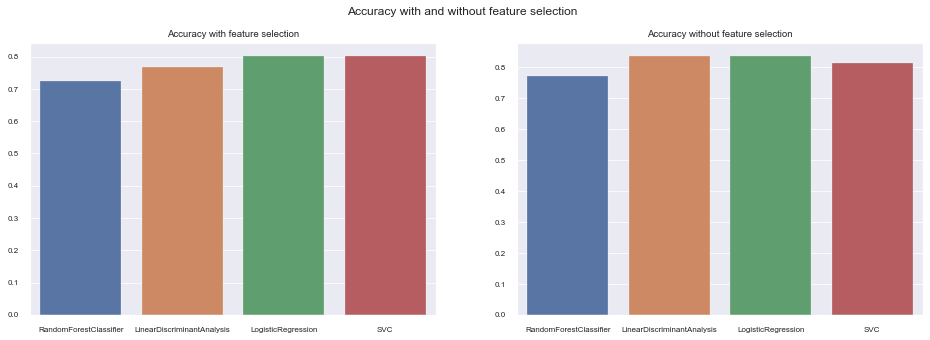

In [27]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
f.suptitle('Accuracy with and without feature selection')
sns.barplot(x=names, y=accuracy_with, ax=axes[0])
sns.barplot(x=names, y=accuracy_without, ax=axes[1])
axes[0].title.set_text('Accuracy with feature selection')
axes[1].title.set_text('Accuracy without feature selection')
plt.show()

Lets continue with all features!

In [28]:
rf = Model(model=RandomForestClassifier(random_state=0), X=df.iloc[:,:-1], y=df.iloc[:,-1])
LDA = Model(model=LinearDiscriminantAnalysis(), X=df.iloc[:,:-1], y=df.iloc[:,-1])
lr = Model(model=LogisticRegression(penalty='l2', random_state=0), X=df.iloc[:,:-1], y=df.iloc[:,-1])
SVM = Model(model=SVC(gamma='scale', probability=True, random_state=0), X=df.iloc[:,:-1], y=df.iloc[:,-1])

RandomForestClassifier Model training..
LinearDiscriminantAnalysis Model training..
LogisticRegression Model training..
SVC Model training..


#### Lets plot the roc curve

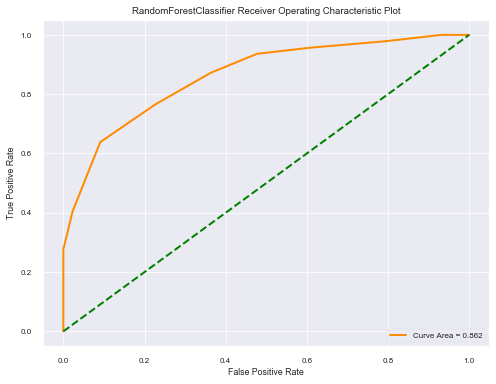

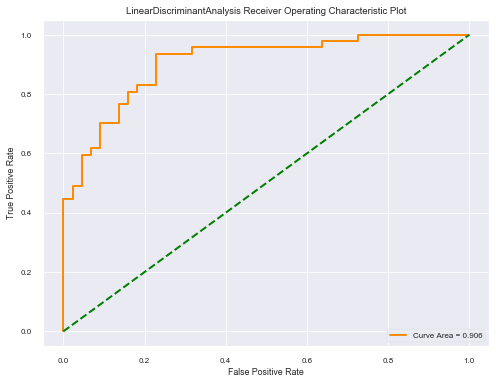

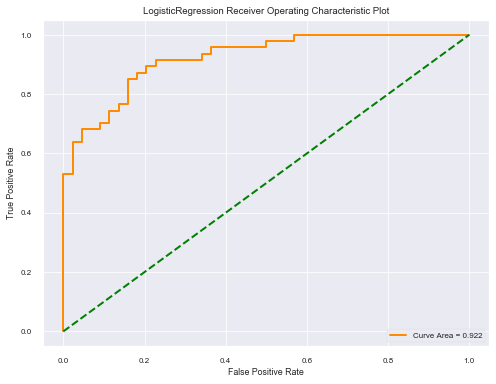

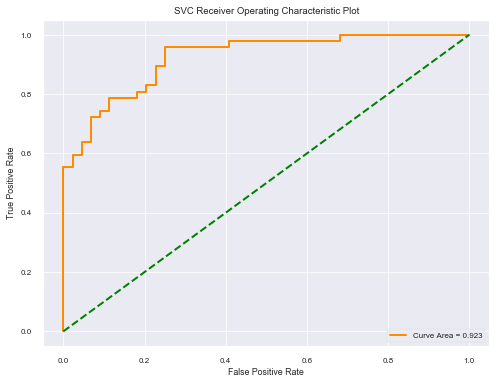

In [29]:
models = [rf, LDA, lr, SVM]
for model in models:
    model.rocCurve()

### Stacking models

In [107]:
skfold = StratifiedKFold(n_splits=10, random_state=0, shuffle=False)
X, X_val, y, y_val = train_test_split(df.iloc[:,:-1], df.iloc[:,-1] ,test_size=0.3, random_state=0)
rf = RandomForestClassifier(random_state=0)
LDA = LinearDiscriminantAnalysis()
lr = LogisticRegression(penalty='l2', random_state=0)
SVM = SVC(gamma='scale', probability=True, random_state=0)

In [108]:
x_data, y_data, y_SVM, y_cart, y_LDA, y_lr = list(),list(),list(),list(),list(),list()
for train_idx, test_idx in skfold.split(X, y):
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y.values[train_idx], y.values[test_idx]
    x_data.extend(X_test)
    y_data.extend(y_test)
    # fit and make predictions with randomforest
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict_proba(X_test)[:,0]
    y_cart.extend(y_pred_rf)
    # fit and make predictions with LinearDiscriminantAnalysis
    LDA.fit(X_train, y_train)
    y_pred_LDA = LDA.predict_proba(X_test)[:,0]
    y_LDA.extend(y_pred_LDA)
    # fit and make predictions with LogisticRegression
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict_proba(X_test)[:,0]
    y_lr.extend(y_pred_lr)
    # fit and make predictions with SVC
    SVM.fit(X_train, y_train)
    y_pred_SVM = SVM.predict_proba(X_test)[:,0]
    y_SVM.extend(y_pred_SVM)

In [109]:
def meta_dataset(x_data, y_pred_rf, y_pred_LDA, y_pred_lr, y_pred_SVM):
    # convert to columns
    y_pred_rf = np.array(y_pred_rf).reshape((len(y_pred_rf), 1))
    y_pred_LDA = np.array(y_pred_LDA).reshape((len(y_pred_LDA), 1))
    y_pred_lr = np.array(y_pred_lr).reshape((len(y_pred_lr), 1))
    y_pred_SVM = np.array(y_pred_SVM).reshape((len(y_pred_SVM), 1))
    # stack as separate columns
    X_meta = np.hstack((x_data,y_pred_rf,y_pred_LDA,y_pred_lr,y_pred_SVM))
    return X_meta

In [110]:
X_meta = meta_dataset(x_data, y_cart, y_LDA, y_lr, y_SVM)

In [111]:
# fit final submodels and meta model
rf.fit(X, y)
LDA.fit(X, y)
lr.fit(X, y)
SVM.fit(X, y)
meta_model = SVC(gamma='scale', probability=True, random_state=0)
meta_model.fit(X_meta, y_data)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [112]:
# make predictions with stacked model
def stack_prediction(model1, model2, model3, model4, meta_model, X):
    # make predictions
    y_pred1 = model1.predict_proba(X)[:, 0]
    y_pred2 = model2.predict_proba(X)[:, 0]
    y_pred3 = model3.predict_proba(X)[:, 0]
    y_pred4 = model4.predict_proba(X)[:, 0]
    # create input dataset
    X_meta = meta_dataset(X, y_pred1, y_pred2, y_pred3, y_pred4)
    # predict
    return meta_model.predict(X_meta)

In [113]:
# evaluate sub models on hold out dataset
acc1 = accuracy_score(y_val, rf.predict(X_val))
acc2 = accuracy_score(y_val, LDA.predict(X_val))
acc3 = accuracy_score(y_val, lr.predict(X_val))
acc4 = accuracy_score(y_val, SVM.predict(X_val))
print('rf Accuracy: %.3f, LDA Accuracy: %.3f, lr Accuracy: %.3f, SVM Accuracy: %.3f' % (acc1, acc2, acc3, acc4))
# evaluate meta model on hold out dataset
y_pred = stack_prediction(rf, LDA, lr, SVM, meta_model, X_val)
acc = accuracy_score(y_val, y_pred)
print('Meta Model Accuracy: %.3f' % (acc))

rf Accuracy: 0.769, LDA Accuracy: 0.835, lr Accuracy: 0.835, SVM Accuracy: 0.813
Meta Model Accuracy: 0.824


We can see that stacking the models not achieved better result. One option is to tweak the hyper parameters. Another option is to use different models.  